# Practical machine learning and deep learning. Lab 6

# Transfer Learning in Computer Vision

# [Competition](https://www.kaggle.com/t/17ac6cc24170468fb7bc3bf5bd9a5b23)

## Goal

In this lab you will implement clothes classifier using a pretrained model. You are allowed to use any pretrained model that you know (e.g. VGG, ResNet, etc.)

## Submission

Submission format is described at competition page.

> Remember, you can use any structure of the solution. The template classes/function in this file is just the tip for you.

In [352]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(0)

## Data reading and preprocessing

Prepare a class for FashionMNIST dataset to easily read data and apply transformations when retrieving examples.

In [353]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms


class FashionMNISTDataset(Dataset):
    '''Dataset class for FashionMNIST'''

    def __init__(self, csv_path, train=True):
        ''' Read data and prepare tranforms

            Args:
            - csv_path(str): full name of the csv file
            - train(bool): is train set loaded, determines whether to return labels
        '''
        self.csv_path = csv_path
        self.train = train

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((28, 28)),
#             transforms.Normalize(mean=[0.485], std=[0.229])
        ])

        # Read csv file of the dataset and set index_col to 0
        self.fm_raw = pd.read_csv(csv_path, index_col=0)

        if train:
            # Extract the pixel values of the images as a numpy array
            self.images = self.fm_raw.iloc[:, :-1].values / 255
            # Reshape images to have 28x28 shape
            self.images = self.images.reshape((-1, 28,28))
            # Make pixels vary from 0 to 1
            self.images = self.images
            # The last column of the dataframe stores that labels. Extract them.
            self.labels = self.fm_raw.iloc[:, -1].values
        else:
            # Extract the pixel values of the images as a numpy array
            self.images = self.fm_raw.values / 255
            # Reshape images to have 28x28 shape
            self.images = self.images.reshape((-1, 28,28))
            # Make pixels vary from 0 to 1
            self.images = self.images
            # There is no labels in the test dataset, so they are set to None
            self.labels = None

    def __getitem__(self, index):
        '''Returns the data of the example at the given index'''
        if self.train:
            # Get images at the given index
            images = self.images[index]
            # Transform the images
            transformed_images = self.transform(images)
#             print(transformed_images)
            # Get labels at the given index
            labels = self.labels[index]
            # Return transformed_images and labels as a pair
            return transformed_images, labels
        else:
            # Get images at the given index
            images = self.images[index]
            # Transform the images
            transformed_images = self.transform(images)
            # Return only transformed images since it is a testing subset
            return transformed_images

    def __len__(self):
        '''Returns length of the dataset'''
        return len(self.images)

Read data and prepare a dataset

In [354]:
import os

dir = '/kaggle/input/pmldl-week-6-transfer-learning-in-cv'
filename = 'fashion_mnist_train.csv'
full_filename = os.path.join(dir, filename)

dataset = FashionMNISTDataset(csv_path=full_filename, train=True)

Split the dataset into training and validation subsets using `random_split`

In [355]:
from torch.utils.data import random_split

# Set percentage of data to use as a training subset
train_ratio = 0.8

train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, test_size])

Make dataloader to perform batching and apply transformations

In [356]:
from torch.utils.data import DataLoader

# Set the batch size
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Visually check the images

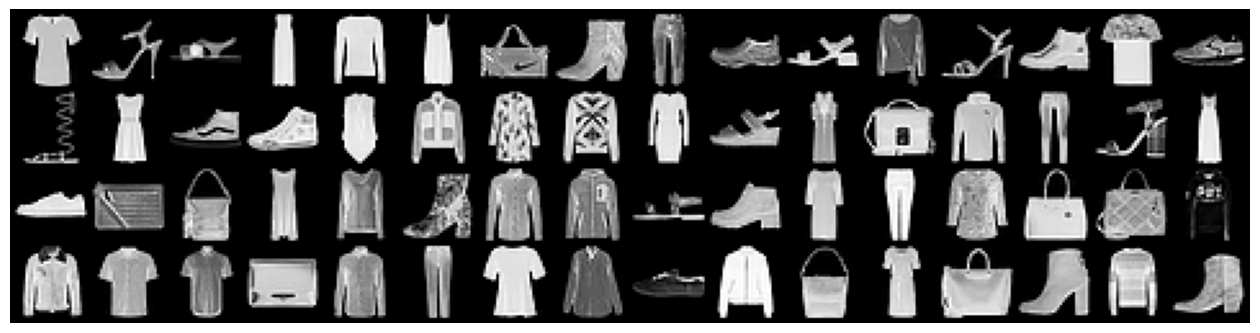

In [357]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

for images, _ in train_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Model Implementation
Implement a PyTorch model that uses a pretrained model for computer vision to classify the clothes. You are allowed to use any models initially trained for other tasks (e.g. VGG, ResNet, etc). You may experiment with [freezing](https://pytorch.org/docs/master/notes/autograd.html#setting-requires-grad) some layers of the pretrained model. If you are interested, you may try to build your own CNN model for FashionMNIST classification.

In [358]:
import torchvision.models as models
import torch.nn as nn

class FashionMNISTModel(nn.Module):
    '''PyTorch model for FashionMNIST classification'''
    def __init__(self, in_channels=1):
        '''Sets the pretrained model and makes specific modifications'''
        super(FashionMNISTModel, self).__init__()
        self.model = models.resnet50(pretrained=True)
        # apply one dim image
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.custom_layers = nn.Sequential(
#             nn.Linear(2048, 512),  
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),        # for regularization
#             nn.Linear(512, 10),  
#         )
        self.model.fc = nn.Linear(2048, 10)
    
    def forward(self, x):
        '''Determines the sequence of actions to classify images x'''
#     print(self.model(x).shape)
        return self.model(x)
        return self.custom_layers(self.model(x))

In [359]:
for images, _ in train_loader:
#     print(images[0])
#     print(images, _)
    print(FashionMNISTModel().to(device)(images.float().to('cuda')).size())
    break

torch.Size([64, 10])


In [360]:
# Select the where to perform calculations
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Create an instance of the model and pass its weights to the device
model = FashionMNISTModel().to(device)
# Set the loss function
loss_function = nn.CrossEntropyLoss()
# Set the opimizer
optimizer = torch.optim.Adam(model.parameters())

## Model Training

Fine-tuning of the pretrained model on our specific task of clothes classification.

Here are utility functions to calculate and show metrics:

In [361]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_metric(metric_fn, true_y, pred_y):
    if metric_fn != accuracy_score:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)

def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

Training loop

In [362]:
from tqdm import tqdm

epochs = 7

losses = []
batches = len(train_loader)
val_batches = len(val_loader)

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    total_loss = 0

    # progress bar
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  --------------------
    # set model to training
    model.train()

    for i, data in progress:
        images, labels = data
        labels = labels.to(device)
        
        optimizer.zero_grad()

        # training step for single batch
        outputs = model(images.float().to(device))
#         print(outputs.shape, labels.shape)
        loss = loss_function(outputs, labels)
    
        loss.backward()
        optimizer.step()

        # update running training loss
        current_loss = loss.item()
        total_loss += current_loss * images.size(0)

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # ----------------- VALIDATION  -----------------
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []

    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            labels = labels.to(device)

            outputs = model(images.float().to(device))

            # update running validation loss
            val_losses += loss_function(outputs, labels) * images.size(0)

            predicted_classes = torch.argmax(outputs, dim=1)

            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy),
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, labels.cpu(), predicted_classes.cpu())
                )

    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches)

Loss: 31.8791: 100%|██████████| 750/750 [00:34<00:00, 21.98it/s]


Epoch 1/7, training loss: 31.879127758026122, validation loss: 23.54285430908203
	     precision: 0.8676
	        recall: 0.8595
	            F1: 0.8491
	      accuracy: 0.8597


Loss: 24.8744: 100%|██████████| 750/750 [00:34<00:00, 22.04it/s]


Epoch 2/7, training loss: 24.874435769399007, validation loss: 21.775074005126953
	     precision: 0.8776
	        recall: 0.8675
	            F1: 0.8600
	      accuracy: 0.8688


Loss: 19.1256: 100%|██████████| 750/750 [00:34<00:00, 22.00it/s]


Epoch 3/7, training loss: 19.125568791071572, validation loss: 19.347639083862305
	     precision: 0.8915
	        recall: 0.8904
	            F1: 0.8803
	      accuracy: 0.8906


Loss: 21.9954: 100%|██████████| 750/750 [00:33<00:00, 22.08it/s]


Epoch 4/7, training loss: 21.99544653193156, validation loss: 28.543710708618164
	     precision: 0.8383
	        recall: 0.8317
	            F1: 0.8133
	      accuracy: 0.8296


Loss: 22.1630: 100%|██████████| 750/750 [00:33<00:00, 22.10it/s]


Epoch 5/7, training loss: 22.163003844579062, validation loss: 20.272720336914062
	     precision: 0.8827
	        recall: 0.8826
	            F1: 0.8719
	      accuracy: 0.8840


Loss: 17.7328: 100%|██████████| 750/750 [00:33<00:00, 22.13it/s]


Epoch 6/7, training loss: 17.732770575205485, validation loss: 17.54026222229004
	     precision: 0.8974
	        recall: 0.8970
	            F1: 0.8887
	      accuracy: 0.8980


Loss: 15.5404: 100%|██████████| 750/750 [00:34<00:00, 21.95it/s]


Epoch 7/7, training loss: 15.540433175404866, validation loss: 17.228281021118164
	     precision: 0.9033
	        recall: 0.9019
	            F1: 0.8946
	      accuracy: 0.9031


## Inference
Produce labels on the testing images

Load the dataset in the testing mode

In [368]:
import os

dir = '/kaggle/input/pmldl-week-6-transfer-learning-in-cv/'
filename = 'fashion_mnist_test_data.csv'
full_filename = os.path.join(dir, filename)

test_dataset = FashionMNISTDataset(csv_path=full_filename, train=False)

Make a loader of the testing dataset

In [369]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Make predictions and generate a submission file

In [370]:
predictions = []

with torch.no_grad():
    model.eval()
    for i, images in enumerate(test_loader):

        outputs = model(images.float().to(device))
        for x in list(torch.argmax(outputs, dim=1).reshape(-1)):
            predictions.append(x.item())
        
predictions[:20]

[8, 2, 2, 9, 2, 1, 3, 7, 1, 2, 5, 1, 2, 3, 0, 3, 7, 1, 0, 9]

In [378]:
# generate the submission file
submission_df = pd.DataFrame(columns=['id', 'label'])
submission_df['id'] = test_dataset.fm_raw.index
submission_df['label'] = predictions
submission_df.to_csv('submission.csv', index=None)
print('Done')

Done


In [377]:
!ls .